# Seismic Tomography

<a target="_blank" href="https://colab.research.google.com/github/AI4EPS/EPS130_Seismology/blob/main/notebooks/tomography_lecture.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

In the travel times lecture, we solved the **forward problem**: given a velocity model, compute travel times. Now we flip the question — given observed travel times, can we **recover the velocity structure**? This is the **inverse problem**, and it's the foundation of seismic tomography.

In [ ]:
# Install dependencies
!pip install netCDF4 cartopy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# For global tomography section (install with: pip install netCDF4 cartopy)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from pathlib import Path
import urllib.request

In [3]:
def build_G(p_values, v_true, dz):
    """Build the path-length matrix G. G[i,j] = total path length of ray i in layer j (two-way)."""
    n_rays, n_layers = len(p_values), len(v_true)
    G = np.zeros((n_rays, n_layers))
    for i, p in enumerate(p_values):
        for j in range(n_layers):
            if p >= 1.0 / v_true[j]:
                break
            cos_theta = np.sqrt(1 - (p * v_true[j])**2)
            G[i, j] = 2 * dz[j] / cos_theta
    return G

def trace_straight_ray(x_src, z_src, x_rec, z_rec, nx, nz, dx_block, dz_block):
    """Compute path lengths of a straight ray through a 2D grid.
    Returns a 1D array of length nx*nz with the path length in each block."""
    path = np.zeros(nx * nz)
    ray_dx = x_rec - x_src
    ray_dz = z_rec - z_src
    ray_len = np.sqrt(ray_dx**2 + ray_dz**2)

    t_crossings = [0.0, 1.0]
    for i in range(nx + 1):
        x_line = i * dx_block
        if abs(ray_dx) > 1e-12:
            t = (x_line - x_src) / ray_dx
            if 0 < t < 1:
                t_crossings.append(t)
    for j in range(nz + 1):
        z_line = j * dz_block
        if abs(ray_dz) > 1e-12:
            t = (z_line - z_src) / ray_dz
            if 0 < t < 1:
                t_crossings.append(t)

    t_crossings = sorted(set(t_crossings))

    for a, b in zip(t_crossings[:-1], t_crossings[1:]):
        t_mid = (a + b) / 2
        x_mid = x_src + t_mid * ray_dx
        z_mid = z_src + t_mid * ray_dz
        ix = int(np.clip(x_mid / dx_block, 0, nx - 1))
        iz = int(np.clip(z_mid / dz_block, 0, nz - 1))
        seg_len = (b - a) * ray_len
        path[iz * nx + ix] += seg_len

    return path

## 1. The Inverse Problem: 1D Inversion

Consider rays traveling through horizontal layers. The travel time of ray $i$ is:

$$t_i = \sum_{j=1}^{M} G_{ij} \, s_j$$

where $s_j = 1/v_j$ is the **slowness** (what we want to find) and $G_{ij}$ is the **path length** of ray $i$ in layer $j$. In matrix form: $\mathbf{Gm} = \mathbf{d}$.

| Symbol | Meaning | Size |
|--------|---------|------|
| $\mathbf{G}$ | Path-length matrix | $N_{\text{rays}} \times M_{\text{layers}}$ |
| $\mathbf{m}$ | Slowness in each layer | $M_{\text{layers}} \times 1$ |
| $\mathbf{d}$ | Observed travel times | $N_{\text{rays}} \times 1$ |

We set up a 4-layer model with 6 rays at different ray parameters $p$. The path length through each layer is:

$$\ell_{ij} = \frac{2 \, \Delta z_j}{\sqrt{1 - p_i^2 v_j^2}}$$

In [4]:
# True model (unknown to the "observer")
v_true = np.array([4.0, 5.5, 7.0, 8.0])  # km/s
s_true = 1.0 / v_true                      # slowness (s/km)
dz = np.array([3.0, 4.0, 5.0, 6.0])       # layer thicknesses (km)
n_layers = len(v_true)

# Ray parameters for 6 rays (s/km)
p_values = np.array([0.02, 0.05, 0.08, 0.10, 0.12, 0.14])
n_rays = len(p_values)

G = build_G(p_values, v_true, dz)

print("G matrix (path lengths in km):")
print(f"{'p (s/km)':<12}", ''.join(f'Layer {j+1:>5}' for j in range(n_layers)))
for i in range(n_rays):
    print(f"{p_values[i]:<12.2f}", ''.join(f'{G[i,j]:>9.2f}' for j in range(n_layers)))

G matrix (path lengths in km):
p (s/km)     Layer     1Layer     2Layer     3Layer     4
0.02              6.02     8.05    10.10    12.16
0.05              6.12     8.32    10.68    13.09
0.08              6.33     8.91    12.07    15.62
0.10              6.55     9.58    14.00    20.00
0.12              6.84    10.65    18.43    42.86
0.14              7.24    12.54    50.25     0.00


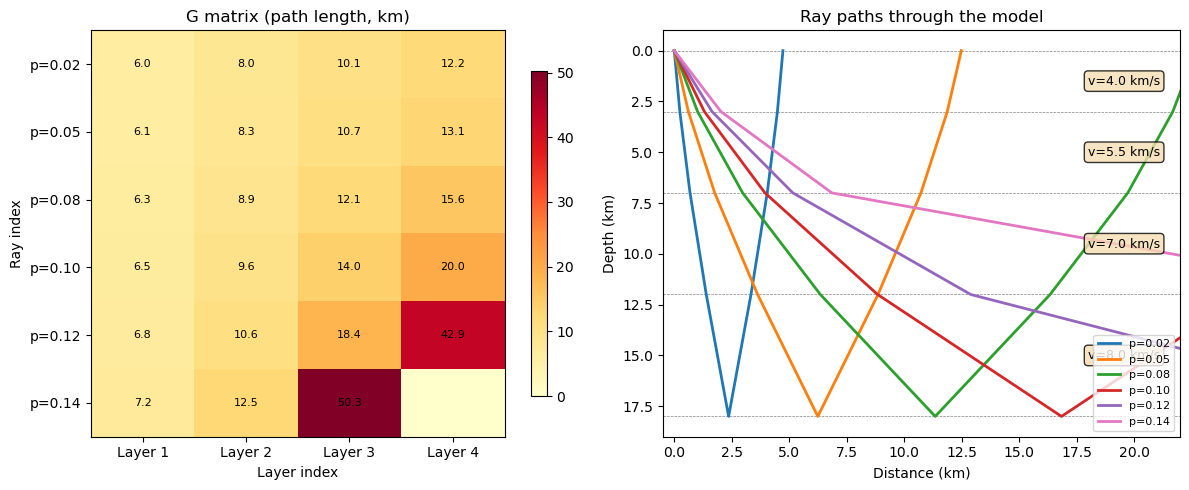

In [5]:
# Visualize the G matrix and ray paths side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: G matrix as image
im = axes[0].imshow(G, aspect='auto', cmap='YlOrRd')
axes[0].set_xlabel('Layer index')
axes[0].set_ylabel('Ray index')
axes[0].set_xticks(range(n_layers))
axes[0].set_xticklabels([f'Layer {j+1}' for j in range(n_layers)])
axes[0].set_yticks(range(n_rays))
axes[0].set_yticklabels([f'p={p:.2f}' for p in p_values])
axes[0].set_title('G matrix (path length, km)')
for i in range(n_rays):
    for j in range(n_layers):
        if G[i, j] > 0:
            axes[0].text(j, i, f'{G[i,j]:.1f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=axes[0], shrink=0.8)

# Right: ray paths
ax = axes[1]
colors = plt.cm.tab10(np.linspace(0, 0.6, n_rays))
z_interfaces = np.concatenate([[0], np.cumsum(dz)])
for z_int in z_interfaces:
    ax.axhline(z_int, color='k', lw=0.5, ls='--', alpha=0.5)
for j in range(n_layers):
    z_mid = z_interfaces[j] + dz[j] / 2
    ax.text(18, z_mid, f'v={v_true[j]} km/s', va='center', fontsize=9,
            bbox=dict(boxstyle='round', fc='wheat', alpha=0.8))

for i, p in enumerate(p_values):
    x, z = 0.0, 0.0
    x_pts, z_pts = [0.0], [0.0]
    for j in range(n_layers):
        if p >= 1.0 / v_true[j]:
            break
        cos_theta = np.sqrt(1 - (p * v_true[j])**2)
        dx = dz[j] * p * v_true[j] / cos_theta
        x += dx
        z += dz[j]
        x_pts.append(x)
        z_pts.append(z)
    x_up = [2 * x_pts[-1] - xi for xi in reversed(x_pts)]
    z_up = list(reversed(z_pts))
    ax.plot(x_pts + x_up[1:], z_pts + z_up[1:], '-', color=colors[i], lw=2, label=f'p={p:.2f}')

ax.set_ylim(sum(dz) + 1, -1)
ax.set_xlim(-0.5, 22)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ray paths through the model')
ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()
plt.show()

### Solving the inverse problem

With more rays than layers ($N > M$), the system is **overdetermined**. The least-squares solution minimizes $||\mathbf{Gm} - \mathbf{d}||^2$:

$$\mathbf{m} = (\mathbf{G}^T \mathbf{G})^{-1} \mathbf{G}^T \mathbf{d}$$

In [6]:
# Forward problem: generate synthetic data (no noise)
d = G @ s_true

# Inverse problem: recover slowness from data
s_recovered, _, _, _ = np.linalg.lstsq(G, d, rcond=None)
v_recovered = 1.0 / s_recovered

print(f"{'Layer':<8} {'v_true (km/s)':<16} {'v_recovered (km/s)':<20} {'Error (%)':<10}")
for j in range(n_layers):
    err = 100 * abs(v_recovered[j] - v_true[j]) / v_true[j]
    print(f"{j+1:<8} {v_true[j]:<16.2f} {v_recovered[j]:<20.4f} {err:<10.4f}")

Layer    v_true (km/s)    v_recovered (km/s)   Error (%) 
1        4.00             4.0000               0.0000    
2        5.50             5.5000               0.0000    
3        7.00             7.0000               0.0000    
4        8.00             8.0000               0.0000    


With perfect data, we recover the model exactly. But real data always has noise.

### Effect of noise and damping

With noisy data, the least-squares solution can become unstable. **Damped least squares** adds a penalty on the model size:

$$\mathbf{m} = (\mathbf{G}^T \mathbf{G} + \varepsilon^2 \mathbf{I})^{-1} \mathbf{G}^T \mathbf{d}$$

- $\varepsilon \to 0$: pure least-squares (fits data closely, but noisy model)
- $\varepsilon$ large: heavily damped (smooth model, but poor data fit)

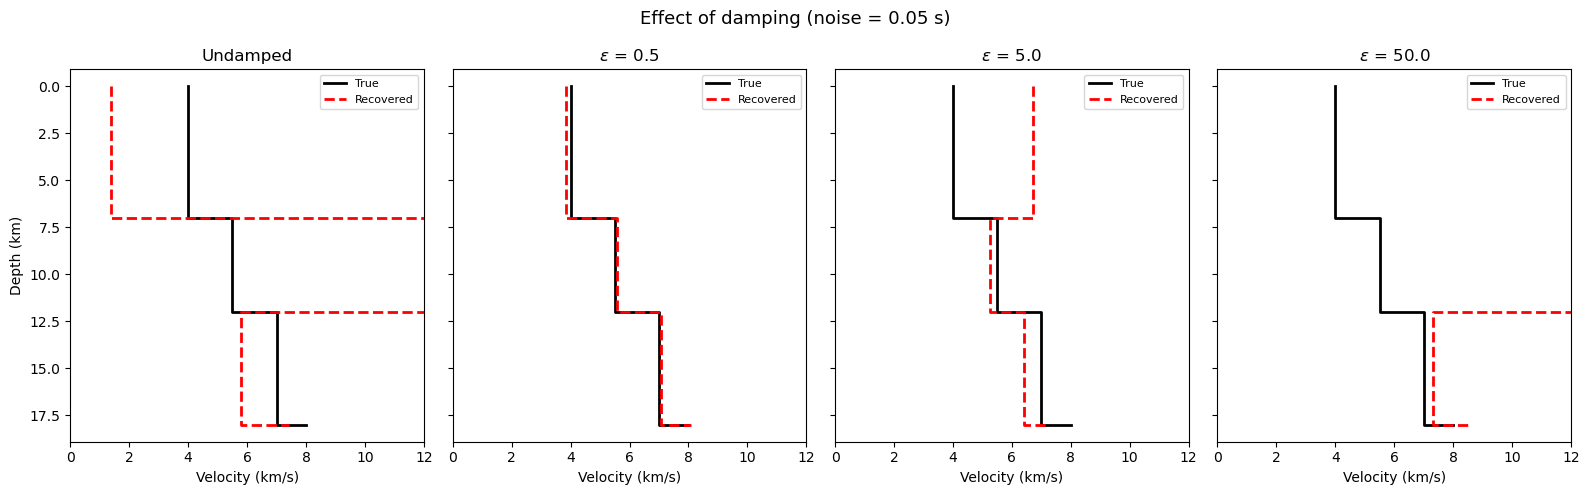

In [7]:
np.random.seed(3)
noise_level = 0.05  # seconds
d_noisy = d + noise_level * np.random.randn(n_rays)

# Undamped least squares
s_undamped, _, _, _ = np.linalg.lstsq(G, d_noisy, rcond=None)

# Damped least squares for several epsilon values
epsilons = [0.5, 5.0, 50.0]
s_damped = {}
for eps in epsilons:
    GtG = G.T @ G + eps**2 * np.eye(n_layers)
    s_damped[eps] = np.linalg.solve(GtG, G.T @ d_noisy)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

cases = [('Undamped', s_undamped)] + [(f'$\\varepsilon$ = {eps}', s_damped[eps]) for eps in epsilons]
for ax, (label, s_inv) in zip(axes, cases):
    v_inv = 1.0 / np.clip(s_inv, 1e-6, None)
    ax.step(np.concatenate([[v_true[0]], v_true]), z_interfaces, 'k-', lw=2, label='True', where='pre')
    ax.step(np.concatenate([[v_inv[0]], v_inv]), z_interfaces, 'r--', lw=2, label='Recovered', where='pre')
    ax.set_xlabel('Velocity (km/s)')
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.set_xlim(0, 12)

axes[0].set_ylabel('Depth (km)')
axes[0].invert_yaxis()
fig.suptitle(f'Effect of damping (noise = {noise_level} s)', fontsize=13)
plt.tight_layout()
plt.show()

### Try it yourself

Change `noise_level` and `epsilons` in the cell above. What happens when noise is very large? What damping value gives the best recovery?

## 2. 2D Block Tomography

The 1D inversion assumed the Earth varies only with depth. In reality, velocity varies **laterally** too. We divide the Earth into a 2D grid of $N_x \times N_z$ blocks, each with unknown slowness $s_k$:

$$t_i = \sum_{k=1}^{M} G_{ik} \, s_k$$

where $G_{ik}$ is the **length of ray $i$ inside block $k$**. For simplicity, we trace **straight rays** between sources and receivers.

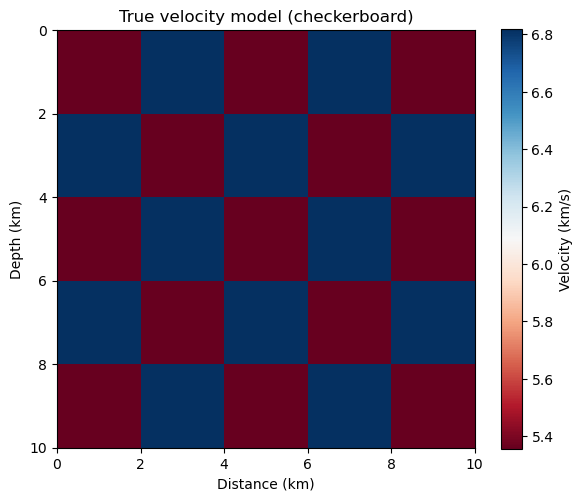

In [8]:
# Grid setup
nx, nz = 10, 10           # number of blocks
dx_block, dz_block = 1.0, 1.0  # block size (km)
n_blocks = nx * nz

# True checkerboard slowness model (2x2 block pattern)
s_background = 1.0 / 6.0   # background slowness (6 km/s)
anomaly = 0.02              # slowness perturbation
s_true = np.full((nz, nx), s_background)
for iz in range(nz):
    for ix in range(nx):
        if ((ix // 2) + (iz // 2)) % 2 == 0:
            s_true[iz, ix] += anomaly
        else:
            s_true[iz, ix] -= anomaly

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(1.0 / s_true, extent=[0, nx*dx_block, nz*dz_block, 0], cmap='RdBu', aspect='equal')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('True velocity model (checkerboard)')
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
plt.tight_layout()
plt.show()

Total rays: 164 (100 top-bottom + 64 left-right)


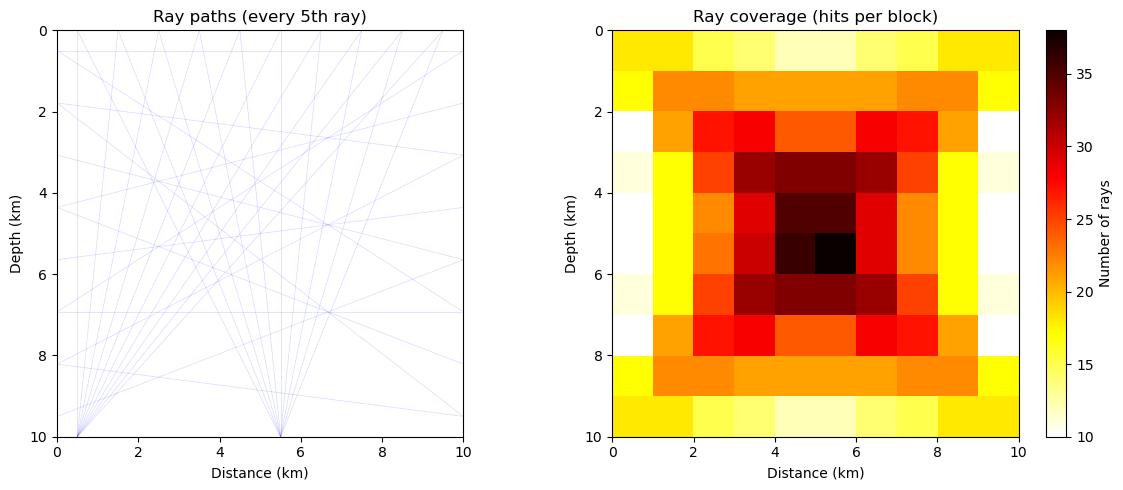

In [9]:
# Source and receiver positions
n_src = 10
n_rec = 10
src_x = np.linspace(0.5, nx * dx_block - 0.5, n_src)
src_z = np.zeros(n_src)           # sources at the top
rec_x = np.linspace(0.5, nx * dx_block - 0.5, n_rec)
rec_z = np.full(n_rec, nz * dz_block)  # receivers at the bottom

# Also add sources on the left, receivers on the right (cross-shooting)
n_side = 8
src_z_side = np.linspace(0.5, nz * dz_block - 0.5, n_side)
src_x_side = np.zeros(n_side)
rec_z_side = np.linspace(0.5, nz * dz_block - 0.5, n_side)
rec_x_side = np.full(n_side, nx * dx_block)

# Build all source-receiver pairs
pairs = []
for i in range(n_src):
    for j in range(n_rec):
        pairs.append((src_x[i], src_z[i], rec_x[j], rec_z[j]))
for i in range(n_side):
    for j in range(n_side):
        pairs.append((src_x_side[i], src_z_side[i], rec_x_side[j], rec_z_side[j]))

n_rays = len(pairs)
print(f"Total rays: {n_rays} ({n_src*n_rec} top-bottom + {n_side*n_side} left-right)")

# Build G matrix
G = np.zeros((n_rays, n_blocks))
for i, (xs, zs, xr, zr) in enumerate(pairs):
    G[i] = trace_straight_ray(xs, zs, xr, zr, nx, nz, dx_block, dz_block)

# Show ray coverage
hit_count = (G > 0).sum(axis=0).reshape(nz, nx)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
for i in range(0, n_rays, 5):
    xs, zs, xr, zr = pairs[i]
    ax.plot([xs, xr], [zs, zr], 'b-', alpha=0.15, lw=0.5)
ax.set_xlim(0, nx * dx_block)
ax.set_ylim(nz * dz_block, 0)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ray paths (every 5th ray)')
ax.set_aspect('equal')

im = axes[1].imshow(hit_count, extent=[0, nx*dx_block, nz*dz_block, 0], cmap='hot_r', aspect='equal')
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Depth (km)')
axes[1].set_title('Ray coverage (hits per block)')
plt.colorbar(im, ax=axes[1], label='Number of rays')
plt.tight_layout()
plt.show()

### Recovering the checkerboard

We generate synthetic travel times, add noise, and invert with damped least squares. Since we're interested in the **perturbation** from a background model, we invert for $\delta s = s - s_0$.

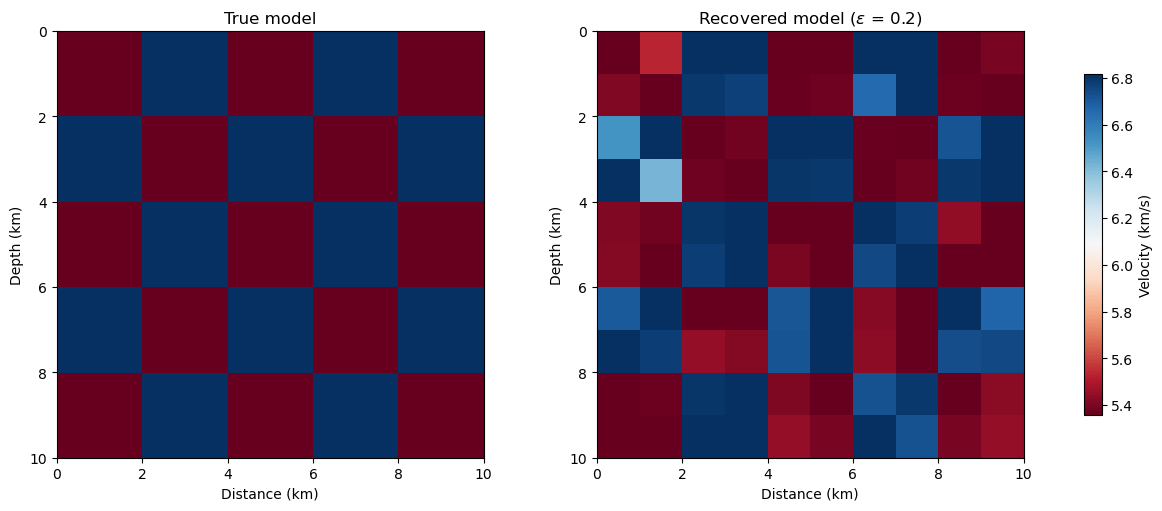

In [10]:
# Forward: compute travel times
s_flat = s_true.ravel()
d_exact = G @ s_flat

# Add noise
np.random.seed(42)
noise = 0.005 * np.random.randn(n_rays)
d_obs = d_exact + noise

# Compute travel time residuals (relative to background model)
d_background = G @ np.full(n_blocks, s_background)
delta_d = d_obs - d_background

# Damped least squares inversion
eps = 0.2
GtG = G.T @ G + eps**2 * np.eye(n_blocks)
delta_s = np.linalg.solve(GtG, G.T @ delta_d)

# Recovered model
s_recovered = (s_background + delta_s).reshape(nz, nx)

# Plot true vs recovered
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
vmin, vmax = (1.0 / s_true).min(), (1.0 / s_true).max()

axes[0].imshow(1.0/s_true, extent=[0, nx*dx_block, nz*dz_block, 0], cmap='RdBu', aspect='equal', vmin=vmin, vmax=vmax)
axes[0].set_title('True model')
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Depth (km)')

im1 = axes[1].imshow(1.0/s_recovered, extent=[0, nx*dx_block, nz*dz_block, 0], cmap='RdBu', aspect='equal', vmin=vmin, vmax=vmax)
axes[1].set_title(f'Recovered model ($\\varepsilon$ = {eps})')
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Depth (km)')

plt.colorbar(im1, ax=axes, label='Velocity (km/s)', shrink=0.8)
plt.show()

### Effect of damping

The damping parameter $\varepsilon$ controls the balance between fitting the data and keeping the model stable. Too little damping amplifies noise; too much damping smears out the structure.

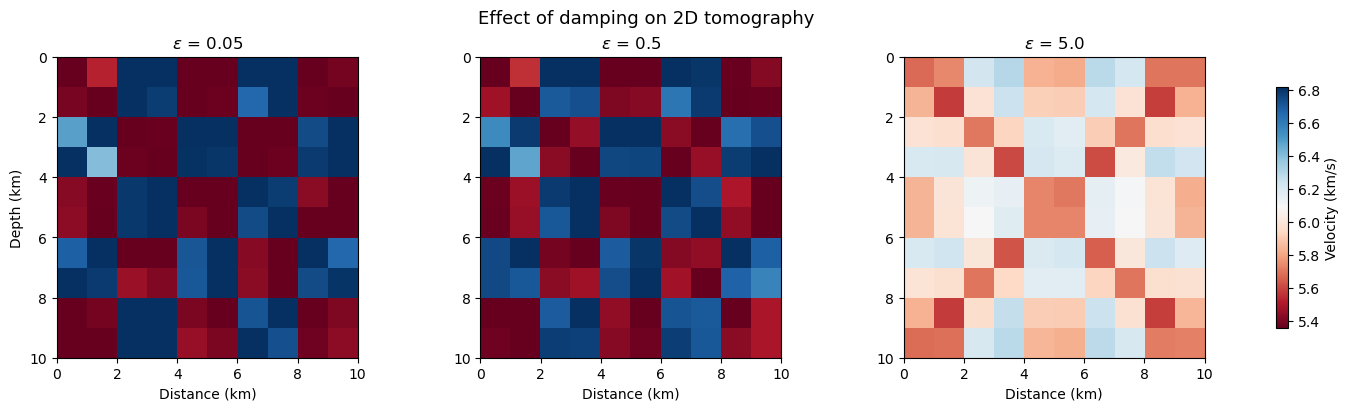

In [11]:
eps_values = [0.05, 0.5, 5.0]
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, eps in zip(axes, eps_values):
    GtG = G.T @ G + eps**2 * np.eye(n_blocks)
    ds = np.linalg.solve(GtG, G.T @ delta_d)
    s_rec = (s_background + ds).reshape(nz, nx)
    im = ax.imshow(1.0/s_rec, extent=[0, nx*dx_block, nz*dz_block, 0],
                   cmap='RdBu', aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(f'$\\varepsilon$ = {eps}')
    ax.set_xlabel('Distance (km)')

axes[0].set_ylabel('Depth (km)')
plt.colorbar(im, ax=axes, label='Velocity (km/s)', shrink=0.8)
fig.suptitle('Effect of damping on 2D tomography', fontsize=13)
plt.show()

### Try it yourself

Go back and change the source/receiver geometry. What happens if you only have top-to-bottom rays (no side-shooting)? Which parts of the model become poorly resolved?

### Spike test (impulse response)

Place a single anomalous block in the model and see how the inversion smears it. This reveals the **point-spread function** — how a point anomaly gets blurred by limited ray coverage.

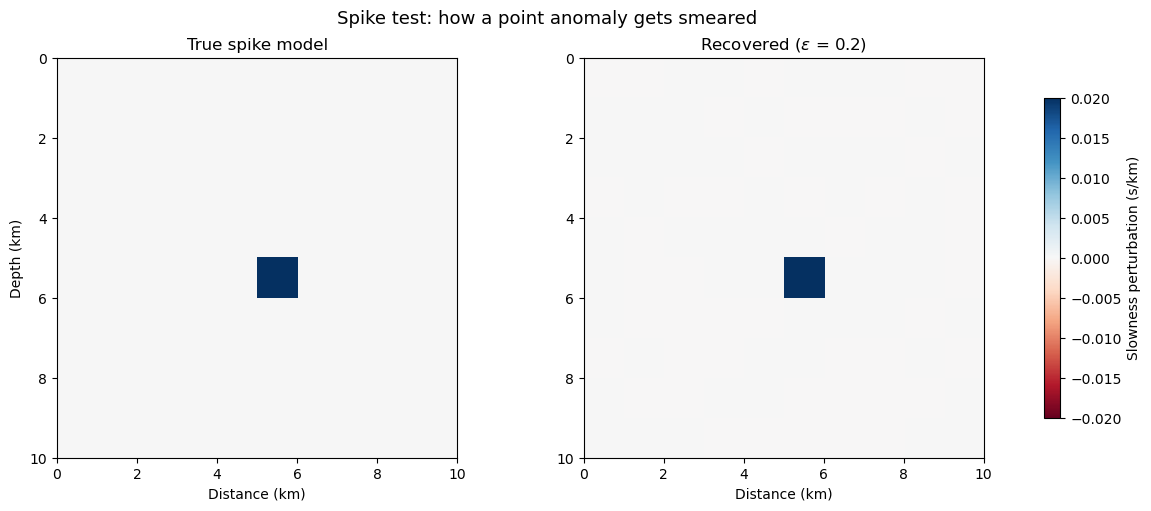

In [12]:
# Spike test: single anomalous block at center
m_spike = np.zeros(n_blocks)
m_spike[5 * nx + 5] = anomaly  # center block

d_spike = G @ m_spike
eps = 0.2
m_spike_rec = np.linalg.solve(G.T @ G + eps**2 * np.eye(n_blocks), G.T @ d_spike)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
vmax_sp = np.abs(m_spike).max()

axes[0].imshow(m_spike.reshape(nz, nx), extent=[0, nx, nz, 0],
               cmap='RdBu', aspect='equal', vmin=-vmax_sp, vmax=vmax_sp)
axes[0].set_title('True spike model')
axes[0].set_ylabel('Depth (km)')

im = axes[1].imshow(m_spike_rec.reshape(nz, nx), extent=[0, nx, nz, 0],
                    cmap='RdBu', aspect='equal', vmin=-vmax_sp, vmax=vmax_sp)
axes[1].set_title(f'Recovered ($\\varepsilon$ = {eps})')

for ax in axes:
    ax.set_xlabel('Distance (km)')
plt.colorbar(im, ax=axes, label='Slowness perturbation (s/km)', shrink=0.8)
plt.suptitle('Spike test: how a point anomaly gets smeared', fontsize=13)
plt.show()

### Textbook example: 20x20 grid (Shearer Exercise 2)

The textbook provides a pre-computed $\mathbf{G}$ matrix and travel time data for a 20x20 block model (400 unknowns) with 118 rays:
- **20 horizontal** rays (one per row)
- **20 vertical** rays (one per column)
- **39 diagonal** rays at +45 degrees
- **39 diagonal** rays at -45 degrees

This is the same setup you will use in the homework.

In [13]:
# Load textbook G matrix (sparse format: ray_index, model_index, path_length)
nx2, nz2 = 20, 20
n_blocks2 = nx2 * nz2

gmat_raw = np.loadtxt('textbook_example/tomo_gmat.txt')
n_rays2 = int(gmat_raw[:, 0].max())
G2 = np.zeros((n_rays2, n_blocks2))
for ray_i, mod_j, path_len in gmat_raw:
    G2[int(ray_i) - 1, int(mod_j) - 1] = path_len

# Load travel time data
data_raw = np.loadtxt('textbook_example/tomo_data.txt')
d2 = data_raw[:, 1]

print(f"Grid: {nx2}x{nz2} = {n_blocks2} blocks")
print(f"Rays: {n_rays2} (20 horizontal + 20 vertical + 39+39 diagonal)")
print(f"G matrix: {G2.shape}, non-zeros: {np.count_nonzero(G2)}")
print(f"Data: {len(d2)} travel time perturbations, {np.sum(d2 != 0)} non-zero")

Grid: 20x20 = 400 blocks
Rays: 118 (20 horizontal + 20 vertical + 39+39 diagonal)
G matrix: (118, 400), non-zeros: 1600
Data: 118 travel time perturbations, 58 non-zero


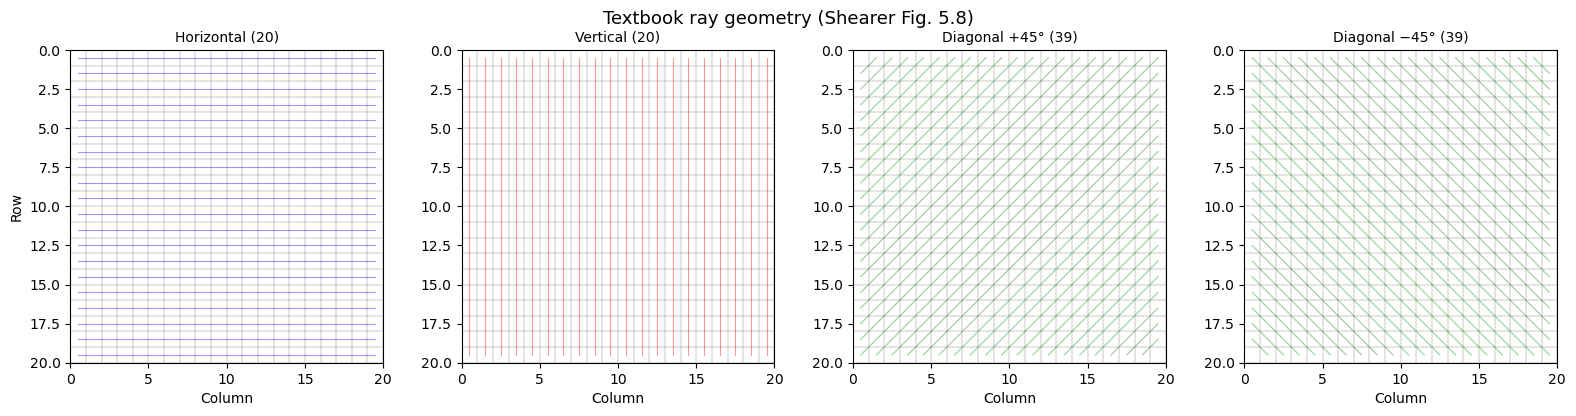

In [14]:
# Visualize the four ray types
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ray_groups = [
    (range(0, 20), 'Horizontal (20)'),
    (range(20, 40), 'Vertical (20)'),
    (range(40, 79), 'Diagonal +45\u00b0 (39)'),
    (range(79, 118), 'Diagonal \u221245\u00b0 (39)'),
]

for ax, (rays, title) in zip(axes, ray_groups):
    for i in range(nx2 + 1):
        ax.axvline(i, color='gray', lw=0.3)
    for j in range(nz2 + 1):
        ax.axhline(j, color='gray', lw=0.3)

    for r in rays:
        blocks = np.where(G2[r] > 0)[0]
        if len(blocks) == 0:
            continue
        rows, cols = blocks // nx2, blocks % nx2
        if title.startswith('Horizontal'):
            order = np.argsort(cols)
            ax.plot([cols[order[0]] + 0.5, cols[order[-1]] + 0.5],
                    [rows[0] + 0.5, rows[0] + 0.5], 'b-', alpha=0.4, lw=0.8)
        elif title.startswith('Vertical'):
            order = np.argsort(rows)
            ax.plot([cols[0] + 0.5, cols[0] + 0.5],
                    [rows[order[0]] + 0.5, rows[order[-1]] + 0.5], 'r-', alpha=0.4, lw=0.8)
        else:
            order = np.argsort(cols)
            ax.plot([cols[order[0]] + 0.5, cols[order[-1]] + 0.5],
                    [rows[order[0]] + 0.5, rows[order[-1]] + 0.5], 'g-', alpha=0.4, lw=0.8)

    ax.set_xlim(0, nx2)
    ax.set_ylim(nz2, 0)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Column')

axes[0].set_ylabel('Row')
plt.suptitle('Textbook ray geometry (Shearer Fig. 5.8)', fontsize=13)
plt.tight_layout()
plt.show()

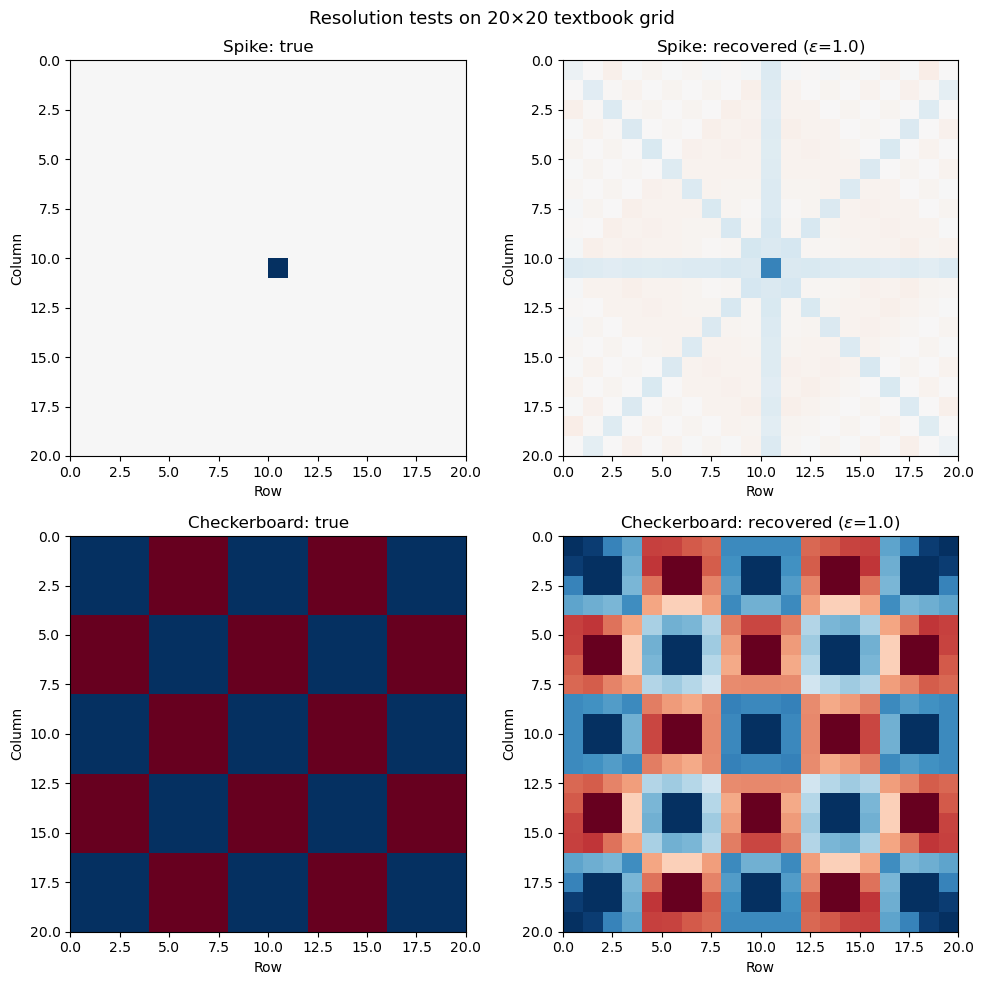

In [15]:
# Spike test and checkerboard test on the textbook 20x20 grid
eps2 = 1.0

# Spike test: single anomaly at center
m_spike2 = np.zeros(n_blocks2)
m_spike2[10 * nx2 + 10] = 1.0
d_spike2 = G2 @ m_spike2
m_spike2_rec = np.linalg.solve(G2.T @ G2 + eps2**2 * np.eye(n_blocks2), G2.T @ d_spike2)

# Checkerboard test: 4x4 block pattern
m_checker2 = np.zeros((nz2, nx2))
for iz in range(nz2):
    for ix in range(nx2):
        m_checker2[iz, ix] = 1.0 if ((ix // 4) + (iz // 4)) % 2 == 0 else -1.0
d_checker2 = G2 @ m_checker2.ravel()
m_checker2_rec = np.linalg.solve(G2.T @ G2 + eps2**2 * np.eye(n_blocks2), G2.T @ d_checker2)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(m_spike2.reshape(nz2, nx2).T, cmap='RdBu', aspect='equal',
                  extent=[0, nz2, nx2, 0], vmin=-1, vmax=1)
axes[0, 0].set_title('Spike: true')

axes[0, 1].imshow(m_spike2_rec.reshape(nz2, nx2).T, cmap='RdBu', aspect='equal',
                  extent=[0, nz2, nx2, 0], vmin=-0.3, vmax=0.3)
axes[0, 1].set_title(f'Spike: recovered ($\\varepsilon$={eps2})')

axes[1, 0].imshow(m_checker2.T, cmap='RdBu', aspect='equal',
                  extent=[0, nz2, nx2, 0], vmin=-1, vmax=1)
axes[1, 0].set_title('Checkerboard: true')

im = axes[1, 1].imshow(m_checker2_rec.reshape(nz2, nx2).T, cmap='RdBu', aspect='equal',
                       extent=[0, nz2, nx2, 0], vmin=-1, vmax=1)
axes[1, 1].set_title(f'Checkerboard: recovered ($\\varepsilon$={eps2})')

for ax in axes.ravel():
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
plt.suptitle('Resolution tests on 20\u00d720 textbook grid', fontsize=13)
plt.tight_layout()
plt.show()

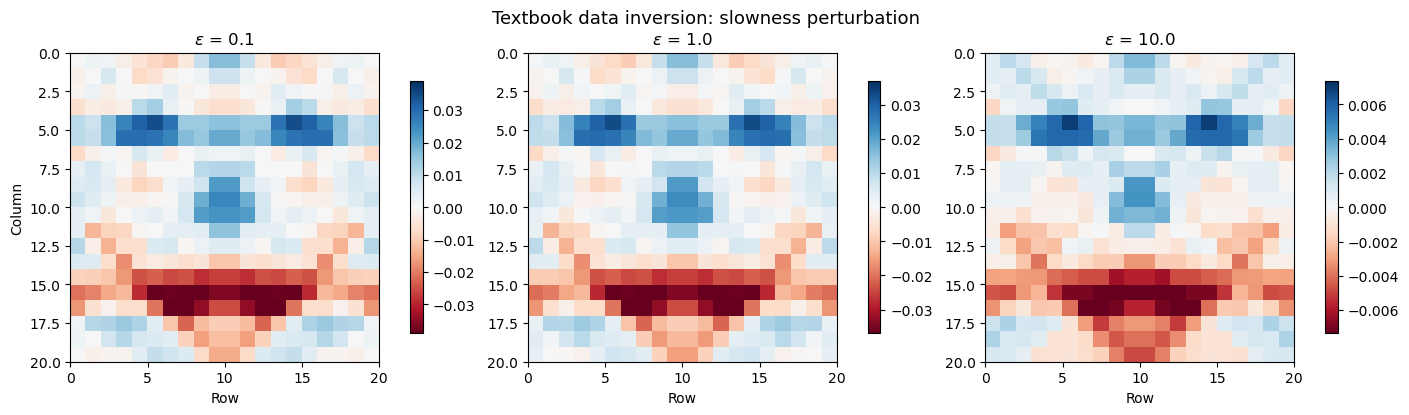

In [16]:
# Invert the textbook travel time data
eps_values2 = [0.1, 1.0, 10.0]
fig, axes = plt.subplots(1, len(eps_values2), figsize=(14, 4), constrained_layout=True)

for ax, eps in zip(axes, eps_values2):
    m_inv = np.linalg.solve(G2.T @ G2 + eps**2 * np.eye(n_blocks2), G2.T @ d2)
    vmax = np.nanpercentile(np.abs(m_inv), 98)
    im = ax.imshow(m_inv.reshape(nz2, nx2).T, extent=[0, nz2, nx2, 0],
                   cmap='RdBu', aspect='equal', vmin=-vmax, vmax=vmax)
    ax.set_title(f'$\\varepsilon$ = {eps}')
    ax.set_xlabel('Row')
    plt.colorbar(im, ax=ax, shrink=0.8)

axes[0].set_ylabel('Column')
plt.suptitle('Textbook data inversion: slowness perturbation', fontsize=13)
plt.show()

## 3. Global Tomography Models

The toy inversions used synthetic data on small grids. Real seismic tomography applies the same principles to millions of travel times. The result: 3D images of Earth's interior.

### S362ANI: Global shear-wave velocity

**S362ANI** (Kustowski et al., 2008) is a global model of shear-wave velocity perturbations from 25 km to the core-mantle boundary (2890 km), available from the [IRIS Earth Model Collaboration](https://ds.iris.edu/ds/products/emc-earthmodels/).

In [17]:
# Download model from IRIS EMC
url = "https://ds.iris.edu/files/products/emc/emc-files/S362ANI_percent.nc"
fname = "S362ANI_percent.nc"
if not Path(fname).exists():
    print(f"Downloading {fname}...")
    urllib.request.urlretrieve(url, fname)
    print("Done.")

ds = nc.Dataset(fname)
lat = ds.variables['latitude'][:]
lon = ds.variables['longitude'][:]
depth = ds.variables['depth'][:]
dvs = np.ma.filled(ds.variables['dvs'][:], fill_value=np.nan)

print(f"Model grid: {len(lat)} lat x {len(lon)} lon x {len(depth)} depths")
print(f"Depth levels (km): {depth}")

Model grid: 91 lat x 181 lon x 25 depths
Depth levels (km): [  25.   50.   75.  100.  125.  150.  200.  250.  300.  350.  400.  500.
  600.  700.  800. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750. 2800.
 2890.]


Each map shows $\delta V_s / V_s$ (%) at a fixed depth. **Blue = fast** (cold, dense material), **Red = slow** (hot, buoyant material).

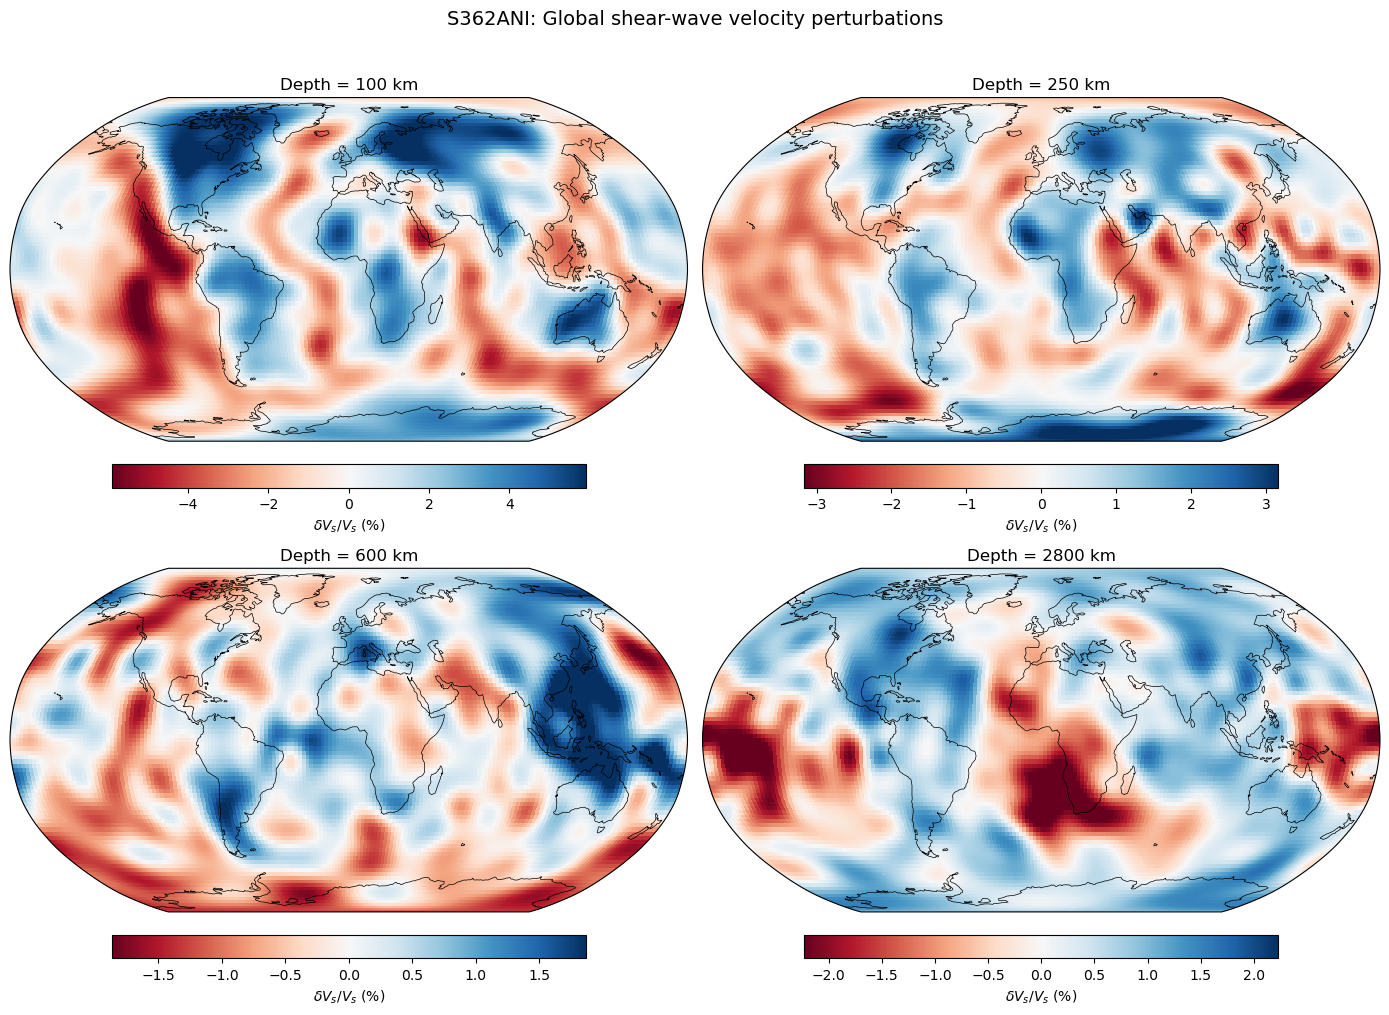

In [18]:
depth_slices = [100, 250, 600, 2800]  # km
LON, LAT = np.meshgrid(lon, lat)

fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                         subplot_kw={'projection': ccrs.Robinson()})

for ax, target_depth in zip(axes.ravel(), depth_slices):
    iz = np.argmin(np.abs(depth - target_depth))
    data = dvs[iz]
    vmax = np.nanpercentile(np.abs(data), 98)

    im = ax.pcolormesh(LON, LAT, data, cmap='RdBu', vmin=-vmax, vmax=vmax,
                       transform=ccrs.PlateCarree(), shading='auto')
    ax.coastlines(lw=0.5)
    ax.set_title(f'Depth = {depth[iz]:.0f} km', fontsize=12)
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05,
                 label='$\\delta V_s / V_s$ (%)', shrink=0.7)

fig.suptitle('S362ANI: Global shear-wave velocity perturbations', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**What to notice:**
- **100 km**: Continents are fast (thick, cold lithosphere); ocean ridges are slow (hot upwelling)
- **250 km**: Slow anomalies under East Africa (hotspot), fast under cratonic continents
- **600 km**: Subducting slabs appear as fast anomalies (e.g., western Pacific)
- **2800 km**: Near the core-mantle boundary — large low-velocity provinces under Africa and the Pacific ("LLSVPs")

### Cross-sections through the Japan subduction zone

A vertical slice reveals how a subducting slab descends into the mantle.

/var/folders/gc/lpnp82h92tv35c_7v97w97cm0000gn/T/ipykernel_69775/3229784002.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


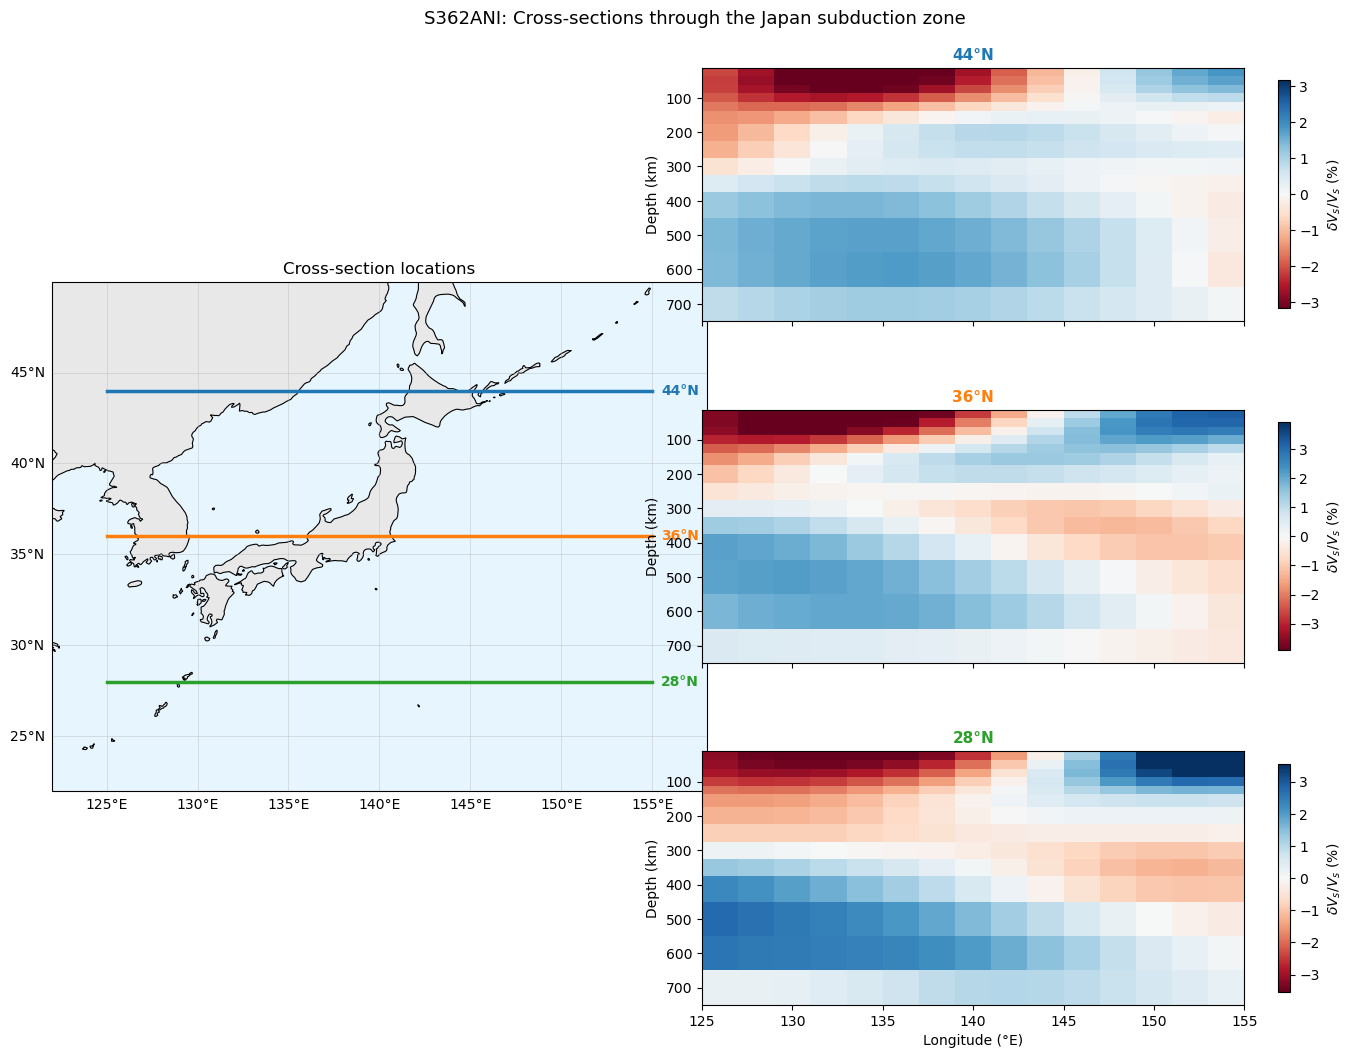

In [19]:
# Cross-sections through the Japan subduction zone at three latitudes
lat_slices = [44, 36, 28]  # Hokkaido, central Honshu, Ryukyu (north to south)
lon_range = (125, 155)
lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
lon_sub = lon[lon_mask]
depth_mask = depth <= 700
depth_sub = depth[depth_mask]

colors = ['C0', 'C1', 'C2']
fig = plt.figure(figsize=(14, 10))

# Map panel (left)
ax_map = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([122, 158, 22, 50], crs=ccrs.PlateCarree())
ax_map.coastlines(lw=0.8)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax_map.add_feature(cfeature.OCEAN, facecolor='lightskyblue', alpha=0.2)
for lat_s, c in zip(lat_slices, colors):
    ax_map.plot([lon_range[0], lon_range[1]], [lat_s, lat_s],
                '-', color=c, lw=2.5, transform=ccrs.PlateCarree(), zorder=5)
    ax_map.text(lon_range[1]+0.5, lat_s, f'{lat_s}\u00b0N', fontsize=10, va='center',
                transform=ccrs.PlateCarree(), color=c, fontweight='bold')
gl = ax_map.gridlines(draw_labels=True, lw=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax_map.set_title('Cross-section locations')

# Cross-section panels (right, stacked north to south)
LON_xs, DEPTH_xs = np.meshgrid(lon_sub, depth_sub)
gs = fig.add_gridspec(len(lat_slices), 2, width_ratios=[1, 1.5], wspace=0.35, hspace=0.35)

for i, (lat_s, c) in enumerate(zip(lat_slices, colors)):
    ilat = np.argmin(np.abs(lat - lat_s))
    dvs_slice = dvs[:, ilat, lon_mask][depth_mask, :]
    vmax = np.nanpercentile(np.abs(dvs_slice), 95)

    ax = fig.add_subplot(gs[i, 1])
    im = ax.pcolormesh(LON_xs, DEPTH_xs, dvs_slice, cmap='RdBu',
                       vmin=-vmax, vmax=vmax, shading='auto')
    ax.invert_yaxis()
    ax.set_ylabel('Depth (km)')
    ax.set_title(f'{lat_s}\u00b0N', color=c, fontweight='bold', fontsize=11)
    plt.colorbar(im, ax=ax, label='$\\delta V_s / V_s$ (%)', shrink=0.9)
    if i == len(lat_slices) - 1:
        ax.set_xlabel('Longitude (\u00b0E)')
    else:
        ax.set_xticklabels([])

plt.suptitle('S362ANI: Cross-sections through the Japan subduction zone', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### MITPS-20: Regional P-wave velocity beneath North America

**MITPS-20** (Golos et al., 2020) is a higher-resolution model of P-wave velocity at depths from 20 to 300 km.

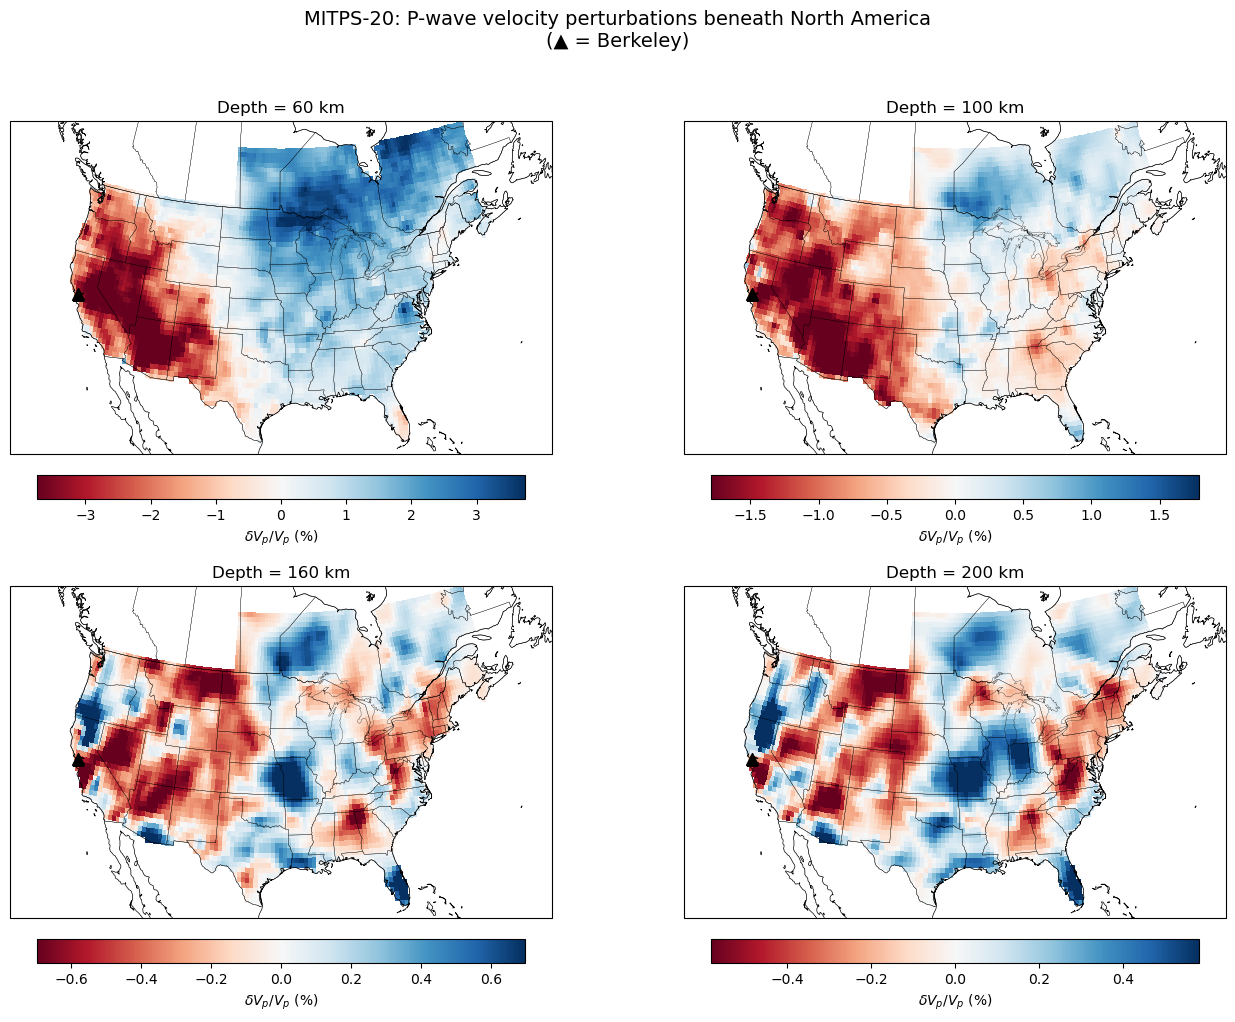

In [20]:
# Download MITPS-20
url2 = "https://ds.iris.edu/files/products/emc/emc-files/MITPS-20.r0.0.nc"
fname2 = "MITPS-20.nc"
if not Path(fname2).exists():
    print(f"Downloading {fname2}...")
    urllib.request.urlretrieve(url2, fname2)
    print("Done.")

ds2 = nc.Dataset(fname2)
lat2 = ds2.variables['latitude'][:]
lon2 = ds2.variables['longitude'][:]
depth2 = ds2.variables['depth'][:]
dvp = np.ma.filled(ds2.variables['dVp'][:], fill_value=np.nan)

depth_slices = [60, 100, 160, 200]
LON2, LAT2 = np.meshgrid(lon2, lat2)

fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                         subplot_kw={'projection': ccrs.AlbersEqualArea(
                             central_longitude=-95, central_latitude=40)})

for ax, target_depth in zip(axes.ravel(), depth_slices):
    iz = np.argmin(np.abs(depth2 - target_depth))
    data = dvp[iz]
    vmax = np.nanpercentile(np.abs(data), 95)

    im = ax.pcolormesh(LON2, LAT2, data, cmap='RdBu', vmin=-vmax, vmax=vmax,
                       transform=ccrs.PlateCarree(), shading='auto')
    ax.coastlines(lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    ax.add_feature(cfeature.STATES, lw=0.2)
    ax.plot(-122.27, 37.87, 'k^', ms=8, transform=ccrs.PlateCarree())
    ax.set_title(f'Depth = {depth2[iz]:.0f} km', fontsize=12)
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05,
                 label='$\\delta V_p / V_p$ (%)', shrink=0.7)

fig.suptitle('MITPS-20: P-wave velocity perturbations beneath North America\n(\u25b2 = Berkeley)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**What to notice:**
- The western US is broadly **slow** (hot, actively deforming: Basin & Range, Yellowstone)
- The eastern US / Canadian Shield is **fast** (cold, thick, ancient cratonic lithosphere)
- The Juan de Fuca slab appears as a fast anomaly under the Pacific Northwest (Cascadia subduction)
- The Yellowstone hotspot shows as a prominent slow anomaly

### Physical interpretation

Seismic velocity perturbations are primarily controlled by **temperature**:

| Anomaly | Velocity | Temperature | Physical interpretation |
|---------|----------|-------------|------------------------|
| Blue (fast) | $\delta V > 0$ | Cold | Subducting slabs, cratonic lithosphere |
| Red (slow) | $\delta V < 0$ | Hot | Mantle plumes, mid-ocean ridges, active tectonics |

Typical velocity perturbations are **1-5%**, corresponding to temperature variations of ~100-500 K.

**Limitations of tomographic models:**
- **Uneven ray coverage**: oceans have fewer stations, so lower resolution in oceanic mantle
- **Regularization**: damping/smoothing means we can never recover the true Earth perfectly
- **Trade-offs**: velocity vs. anisotropy, temperature vs. composition

## Summary

| Concept | Key idea |
|---------|----------|
| Forward vs. inverse | Forward: given model, compute data. Inverse: given data, recover model |
| $\mathbf{Gm} = \mathbf{d}$ | Path-length matrix $\times$ slowness = travel times |
| Damped least squares | $\varepsilon^2 \mathbf{I}$ stabilizes the inversion at the cost of resolution |
| Checkerboard test | Synthetic test showing which parts of the model can be resolved |
| Spike test | Point-spread function — how a point anomaly gets smeared |
| Ray coverage | Blocks sampled by many rays at different angles are best resolved |
| Global models | Same framework scales from toy examples to Earth-scale imaging |